In [105]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

# Neural network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Visualization and data handling
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')

# Setting random seeds to ensure reproducible results
np.random.seed(42)
tf.random.set_seed(42)

print("All modeling libraries imported successfully.")


All modeling libraries imported successfully.


In [106]:
df = pd.read_csv('../data/telco_churn_cleaned.csv')

print("Dataset loaded from EDA:")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nTotalCharges data type: {df['TotalCharges'].dtype}")
print(f"Missing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Drop customerID if it's not useful for prediction
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

print(f"\nData loaded successfully. Shape after removing customerID: {df.shape}")


Dataset loaded from EDA:
Shape: 7043 rows, 21 columns

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...             

In [107]:
df_processed = df.copy()

if 'Churn_Numeric' in df_processed.columns:
    df_processed = df_processed.drop('Churn_Numeric', axis=1)
    print(" Removed Churn_Numeric to prevent data leakage")

df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

# Converting target variable to binary numeric format 
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0})

if 'gender' in df_processed.columns:
    df_processed['gender'] = df_processed['gender'].map({'Male': 1, 'Female': 0})

# SeniorCitizen might be text from EDA 
if 'SeniorCitizen' in df_processed.columns:
    if df_processed['SeniorCitizen'].dtype == 'object':
        df_processed['SeniorCitizen'] = df_processed['SeniorCitizen'].map({'Yes': 1, 'No': 0})

print("Binary encoding completed!")

# Identifying multi-category features for one-hot encoding
multi_category_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

cols_to_encode = [col for col in multi_category_cols if col in df_processed.columns]

# Applying one-hot encoding transformation
df_encoded = pd.get_dummies(df_processed, columns=cols_to_encode, drop_first=True)

print(f"\nShape after encoding: {df_encoded.shape}")
print(f"Features increased from {df.shape[1]} to {df_encoded.shape[1]} columns")
print("\n All categorical variables encoded.")

print("\n Leakage check:")
print(f"Columns in encoded data: {df_encoded.columns.tolist()}")
if 'Churn_Numeric' in df_encoded.columns:
    print(" Warning: Churn_Numeric still present")
else:
    print("No Churn_Numeric found.")


Binary encoding completed!

Shape after encoding: (7043, 31)
Features increased from 20 to 31 columns

 All categorical variables encoded.

 Leakage check:
Columns in encoded data: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
No Churn_Numeric found.


In [108]:
# Separating independent variables (features) from dependent variable (target)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print("Feature columns:", X.shape[1])
print("Total samples:", len(y))
print(f"\nClass distribution:\n{y.value_counts()}")
print(f"\nChurn rate: {y.mean()*100:.2f}%")

# Splitting data - 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print("\nData split completed.")

X.head()

Feature columns: 30
Total samples: 7043

Class distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn rate: 26.54%

Training set: 5634 samples
Testing set: 1409 samples

Data split completed.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,True,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,False,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,False,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,True,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,False,...,False,False,False,False,False,False,False,False,True,False


In [109]:
scaler = StandardScaler()

# Fit on training data and transform both train and test (this is important for NN)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Feature scaling completed using StandardScaler")
print(f"\nTraining set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")
print("\nFeatures are scaled successfully.")


Feature scaling completed using StandardScaler

Training set shape: (5634, 30)
Testing set shape: (1409, 30)

Features are scaled successfully.


In [110]:
def create_neural_network(input_dim):
    model = Sequential([
        # First hidden layer with 64 neurons
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),  # to prevent overfitting
        
        # Second hidden layer with 32 neurons
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        # Output layer with sigmoid activation for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

nn_model = create_neural_network(X_train_scaled.shape[1])

print("Neural Network Architecture:")
nn_model.summary()
print("\nNeural Network model created.")


Neural Network Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)


Neural Network model created.


Training Neural Network...
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7546 - loss: 0.4925 - val_accuracy: 0.7897 - val_loss: 0.4528
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7872 - loss: 0.4451 - val_accuracy: 0.7924 - val_loss: 0.4478
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7874 - loss: 0.4368 - val_accuracy: 0.7870 - val_loss: 0.4476
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7923 - loss: 0.4307 - val_accuracy: 0.7853 - val_loss: 0.4447
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8032 - loss: 0.4249 - val_accuracy: 0.7862 - val_loss: 0.4433
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8034 - loss: 0.4307 - val_accuracy: 0.7853 - val_loss: 0.4410
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7999 - loss: 0.4216 - val_accuracy: 0.7853 - val_loss: 0.4405
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8039 - loss

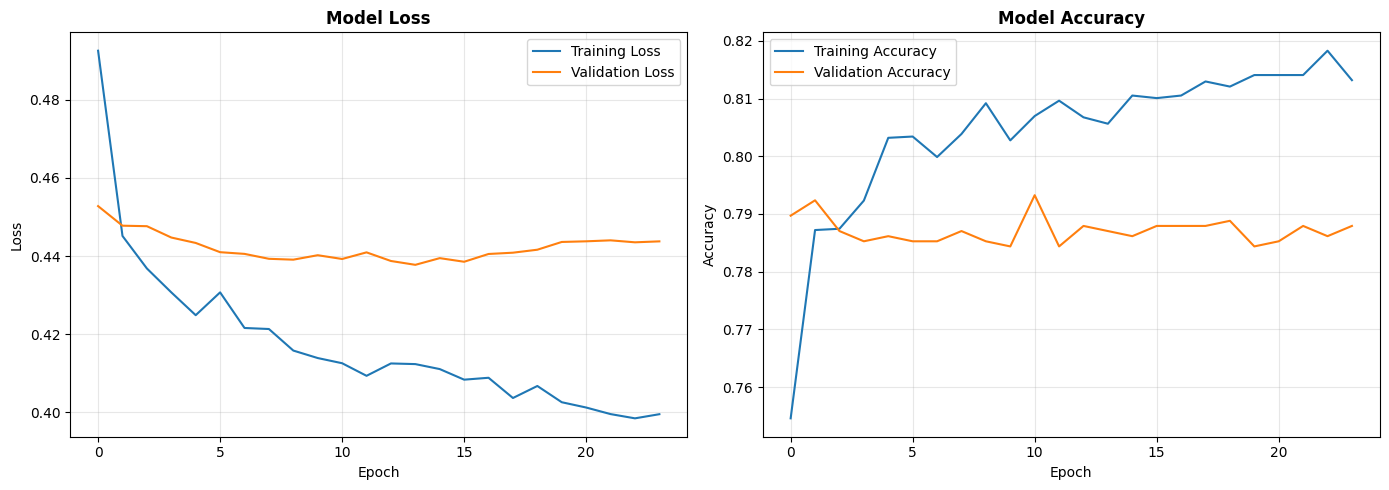

In [111]:
# Early stopp - to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# To train the model
print("Training Neural Network...")

history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # using da 20% of training data for validation
    callbacks=[early_stop],
    verbose=1
)

print("\n Neural Network training completed.")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss progression plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy progression plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


............................
Neural Network Performance
............................
Accuracy:  0.7899
Precision: 0.6168
Recall:    0.5508
F1-Score:  0.5819
ROC-AUC:   0.8366

Confusion Matrix:
[[907 128]
 [168 206]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.88      0.86      1035
       Churn       0.62      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



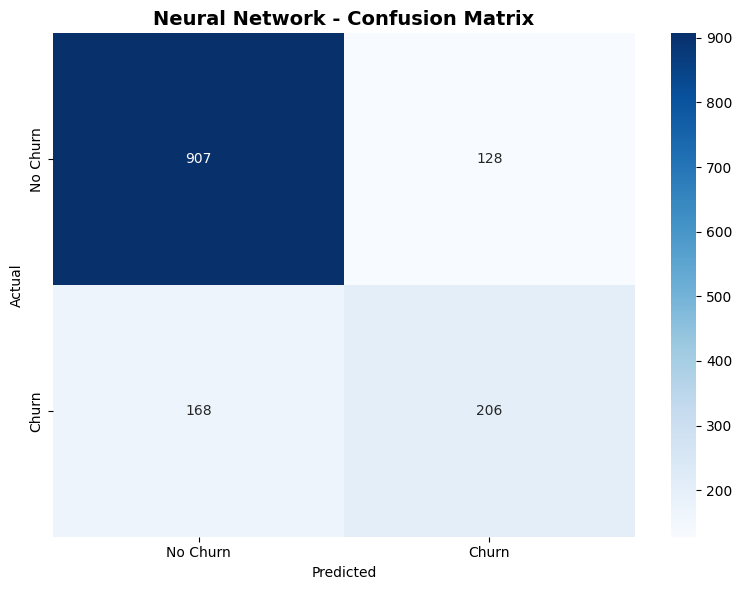


 Neural Network evaluation completed.


In [112]:
# Making prediction
y_pred_nn_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)

# Computing performance metrics
nn_accuracy = accuracy_score(y_test, y_pred_nn)
nn_precision = precision_score(y_test, y_pred_nn)
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)
nn_roc_auc = roc_auc_score(y_test, y_pred_nn_proba)

print("."*28)
print("Neural Network Performance")
print("."*28)
print(f"Accuracy:  {nn_accuracy:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall:    {nn_recall:.4f}")
print(f"F1-Score:  {nn_f1:.4f}")
print(f"ROC-AUC:   {nn_roc_auc:.4f}")

print("\nConfusion Matrix:")
cm_nn = confusion_matrix(y_test, y_pred_nn)
print(cm_nn)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))

# Visualizing confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Neural Network - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\n Neural Network evaluation completed.")


In [113]:
dt_model = DecisionTreeClassifier(random_state=42)

# Train the decision tree model
print("Training Decision Tree...")
dt_model.fit(X_train, y_train)

# prediction
y_pred_dt = dt_model.predict(X_test)
y_pred_dt_proba = dt_model.predict_proba(X_test)[:, 1]

# Computing baseline performance metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_roc_auc = roc_auc_score(y_test, y_pred_dt_proba)

print("\n" + "."*44)
print("Decision tree performance (Before Tuning)")
print("."*44)
print(f"Accuracy:  {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall:    {dt_recall:.4f}")
print(f"F1-Score:  {dt_f1:.4f}")
print(f"ROC-AUC Score:   {dt_roc_auc:.4f}")

print("\n Decision Tree baseline model trained.")


Training Decision Tree...

............................................
Decision tree performance (Before Tuning)
............................................
Accuracy:  0.7410
Precision: 0.5125
Recall:    0.4920
F1-Score:  0.5020
ROC-AUC Score:   0.6610

 Decision Tree baseline model trained.


In [ ]:
# Defining hyperparameter search space
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Initiating grid search with cross-validation
print("Starting hyperparameter tuning for the Decision Tree")

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # optimizing for ROC-AUC metric
    n_jobs=-1,  # using all CPU cores
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n" + "."*27)
print("Best hyperparameters are found")
print("."*27)
print(grid_search.best_params_)
print(f"\nBest cross-validation ROC-AUC score: {grid_search.best_score_:.4f}")

dt_best_model = grid_search.best_estimator_

print("\nHyperparameter tuning process is complete.")


Starting hyperparameter tuning for Decision Tree...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits

...........................
Best hyperparameters found
...........................
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}

Best cross-validation ROC-AUC score: 0.8255

Hyperparameter tuning process completed.


...............................................
Decision tree performance (After Tuning)
...............................................
Accuracy:  0.7921
Precision: 0.6484
Recall:    0.4733
F1-Score:  0.5471
ROC-AUC:   0.8276

Confusion Matrix:
[[939  96]
 [197 177]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.91      0.87      1035
       Churn       0.65      0.47      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



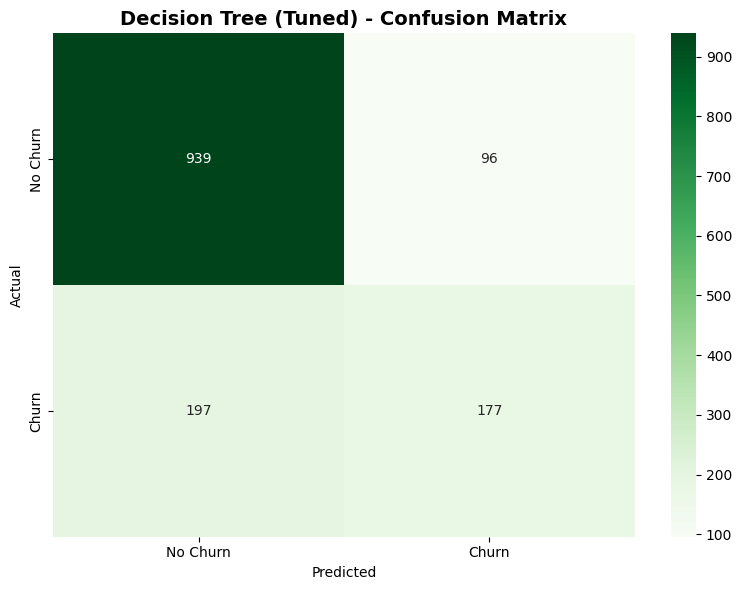


Tuned Decision Tree evaluation completed.


In [ ]:
# Make predictions with da tuned model
y_pred_dt_tuned = dt_best_model.predict(X_test)
y_pred_dt_tuned_proba = dt_best_model.predict_proba(X_test)[:, 1]

# Computing optimized model metrics
dt_tuned_accuracy = accuracy_score(y_test, y_pred_dt_tuned)
dt_tuned_precision = precision_score(y_test, y_pred_dt_tuned)
dt_tuned_recall = recall_score(y_test, y_pred_dt_tuned)
dt_tuned_f1 = f1_score(y_test, y_pred_dt_tuned)
dt_tuned_roc_auc = roc_auc_score(y_test, y_pred_dt_tuned_proba)

print("."*47)
print("Decision tree performance (After Tuning)")
print("."*47)
print(f"Accuracy:  {dt_tuned_accuracy:.4f}")
print(f"Precision: {dt_tuned_precision:.4f}")
print(f"Recall:    {dt_tuned_recall:.4f}")
print(f"F1-Score:  {dt_tuned_f1:.4f}")
print(f"ROC-AUC:   {dt_tuned_roc_auc:.4f}")

print("\nConfusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt_tuned)
print(cm_dt)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt_tuned, target_names=['No Churn', 'Churn']))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Decision Tree (Tuned) - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nTuned Decision Tree evaluation is complete.")


.......................
Model comparison
.......................
   Metric  Neural Network  Decision Tree (Tuned)
 Accuracy        0.789922               0.792051
Precision        0.616766               0.648352
   Recall        0.550802               0.473262
 F1-Score        0.581921               0.547141
  ROC-AUC        0.836563               0.827578

..........................
Performance Difference
..........................
   Metric  Difference (NN - DT)
 Accuracy             -0.002129
Precision             -0.031585
   Recall              0.077540
 F1-Score              0.034780
  ROC-AUC              0.008985


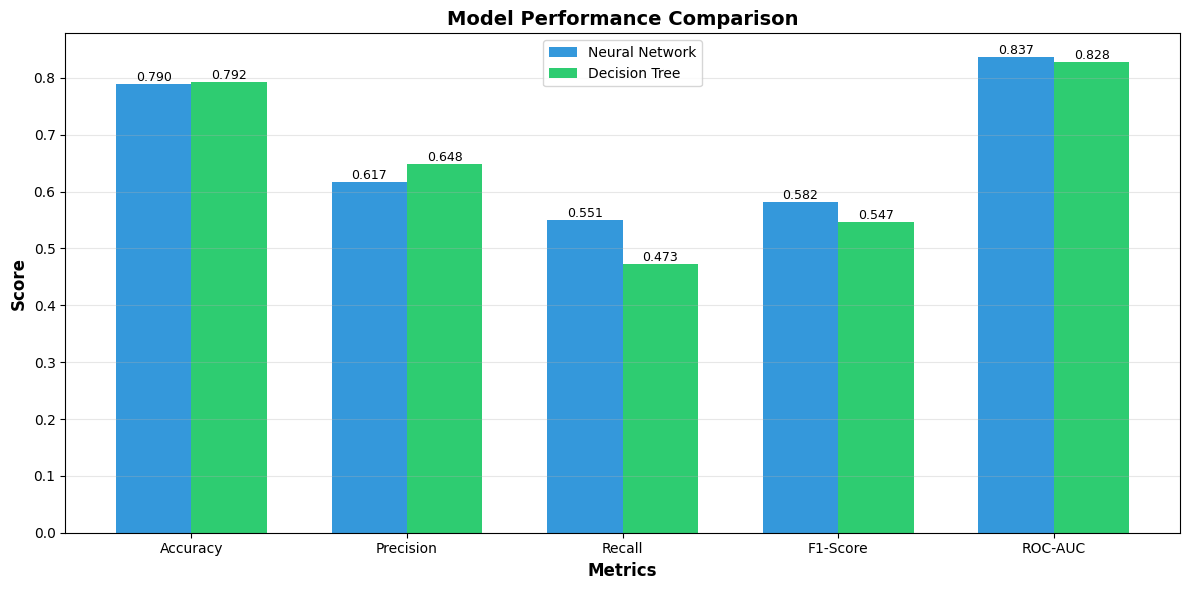


Model comparison completed.


In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Neural Network': [nn_accuracy, nn_precision, nn_recall, nn_f1, nn_roc_auc],
    'Decision Tree (Tuned)': [dt_tuned_accuracy, dt_tuned_precision, 
                               dt_tuned_recall, dt_tuned_f1, dt_tuned_roc_auc]
})

print("."*23)
print("Model comparison")
print("."*23)
print(comparison_df.to_string(index=False))

# Calculating the difference
comparison_df['Difference (NN - DT)'] = (
    comparison_df['Neural Network'] - comparison_df['Decision Tree (Tuned)']
)

print("\n" + "."*26)
print("Performance Difference")
print("."*26)
print(comparison_df[['Metric', 'Difference (NN - DT)']].to_string(index=False))

# Creatving visual comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Neural Network'], width, 
               label='Neural Network', color='#3498db')
bars2 = ax.bar(x + width/2, comparison_df['Decision Tree (Tuned)'], width,
               label='Decision Tree', color='#2ecc71')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nModel comparison is complete")


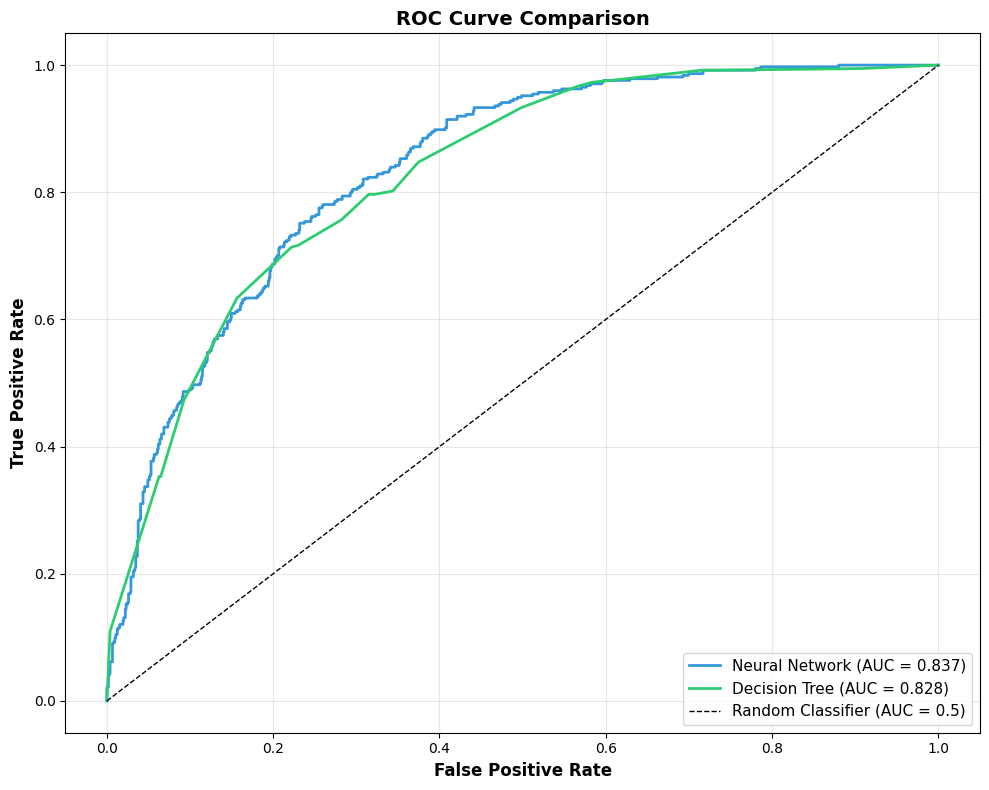

ROC curves plotted.


In [117]:
# Calculate ROC curves coordinates for both models
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_tuned_proba)

# Plot ROC curves for comparison
plt.figure(figsize=(10, 8))

plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_roc_auc:.3f})', 
         linewidth=2, color='#3498db')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_tuned_roc_auc:.3f})',
         linewidth=2, color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("ROC curves plotted.")


...............................................
Top 15 most importnat features (Decision Tree)
...............................................
                           Feature  Importance
                 Contract_Two year    0.360598
                 Contract_One year    0.228817
                            tenure    0.130486
       InternetService_Fiber optic    0.127187
                    MonthlyCharges    0.038554
    PaymentMethod_Electronic check    0.036965
               StreamingMovies_Yes    0.032523
                      TotalCharges    0.031930
   StreamingTV_No internet service    0.012940
                           Partner    0.000000
                      PhoneService    0.000000
                        Dependents    0.000000
                     SeniorCitizen    0.000000
                            gender    0.000000
OnlineSecurity_No internet service    0.000000


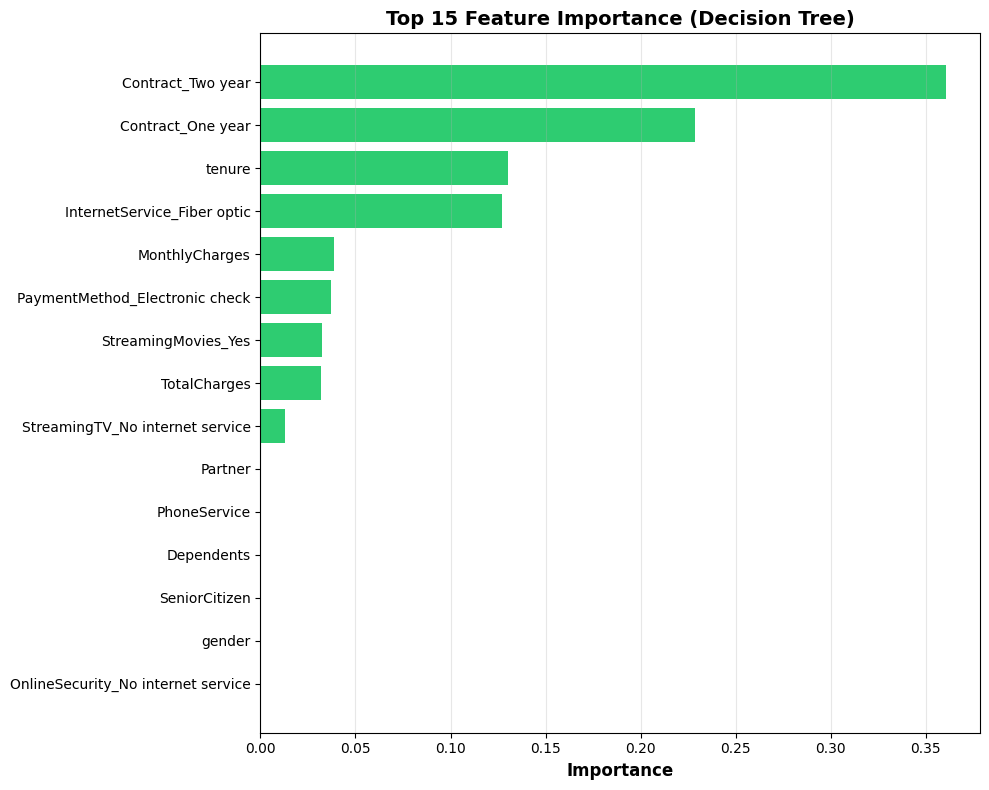


Feature importance analysis completed


In [118]:
#feature importance from Decision Tree
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_best_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display the top 15 features
print("."*47)
print("Top 15 most importnat features (Decision Tree)")
print("."*47)
print(feature_importance.head(15).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['Importance'], color='#2ecc71')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importance (Decision Tree)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nFeature importance analysis completed")


In [119]:
print("."*22)
print("Final Results")
print("."*22)

if nn_roc_auc > dt_tuned_roc_auc:
    better_model = "Neural Network"
    better_score = nn_roc_auc
else:
    better_model = "Decision Tree"
    better_score = dt_tuned_roc_auc

print(f"\n1. Best performing model: {better_model}")
print(f"   - ROC-AUC Score: {better_score:.4f}")

print(f"\n2. Model Strengths:")
print(f"   Neural Network:")
print(f"   - Accuracy: {nn_accuracy:.4f}")
print(f"   - Good at capturing complex non-linear patterns")
print(f"   - Better generalization with proper regularization (Dropout)")

print(f"\n   Decision Tree:")
print(f"   - Accuracy: {dt_tuned_accuracy:.4f}")
print(f"   - Highly interpretable (can see decision rules)")
print(f"   - Fast training and prediction")
print(f"   - No feature scaling required")

print(f"\n3. KEY FINDINGS:")
print(f"   - Most important features: {', '.join(feature_importance.head(3)['Feature'].tolist())}")
print(f"   - Both models show similar performance")
print(f"   - Class imbalance handled through stratified splitting")

print(f"\n4. Recommendations for deployment:")
if better_model == "Neural Network":
    print(f"   - Use Neural Network for better predictive performance")
    print(f"   - Implement regular retraining with new data")
    print(f"   - Monitor performance drift over time")
else:
    print(f"   - Use Decision Tree for better interpretability")
    print(f"   - Easier to explain predictions to business stakeholders")
    print(f"   - Lower computational requirements")

......................
Final Results
......................

1. Best performing model: Neural Network
   - ROC-AUC Score: 0.8366

2. Model Strengths:
   Neural Network:
   - Accuracy: 0.7899
   - Good at capturing complex non-linear patterns
   - Better generalization with proper regularization (Dropout)

   Decision Tree:
   - Accuracy: 0.7921
   - Highly interpretable (can see decision rules)
   - Fast training and prediction
   - No feature scaling required

3. KEY FINDINGS:
   - Most important features: Contract_Two year, Contract_One year, tenure
   - Both models show similar performance
   - Class imbalance handled through stratified splitting

4. Recommendations for deployment:
   - Use Neural Network for better predictive performance
   - Implement regular retraining with new data
   - Monitor performance drift over time
